# test to load local package

## try on dataset c20200927 c20201113 in folder SPOTSAR/test_data


In [1]:
# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex
import fastparquet # fast read/write for large data structures
import sklearn.preprocessing as pre # for data normalisation
from sklearn.metrics import pairwise_distances

import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)



from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
import sys
modulenames = set(sys.modules) & set(globals())
allmodules = [sys.modules[name] for name in modulenames]
print(allmodules)

[<module 'pyproj' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/pyproj/__init__.py'>, <module 'datetime' from '/Applications/anaconda3/envs/PhD/lib/python3.8/datetime.py'>, <module 'numba' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numba/__init__.py'>, <module 'rasterio' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/rasterio/__init__.py'>, <module 'utm' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/utm/__init__.py'>, <module 'copy' from '/Applications/anaconda3/envs/PhD/lib/python3.8/copy.py'>, <module 'os' from '/Applications/anaconda3/envs/PhD/lib/python3.8/os.py'>, <module 'configparser' from '/Applications/anaconda3/envs/PhD/lib/python3.8/configparser.py'>, <module 'glob' from '/Applications/anaconda3/envs/PhD/lib/python3.8/glob.py'>, <module 'fastparquet' from '/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/fastparquet/__init__.py'>, <module 're' from '/Applications/anaconda3/envs/

In [3]:
################ Define user INPUTS #######################
######## please edit the values of this block only ########
###########################################################

# define hillshade file
HS_FILE = './test_data/DEM/TDX_Merapi_WGS84_HS.tif'

# define lon and lat files
LON_FILE = './test_data/CSK_dsc/geo/20200910.lon'
LAT_FILE = './test_data/CSK_dsc/geo/20200910.lat'

# define parameter text file
PARAM_FILE = './test_data/CSK_dsc/params.txt'

# define map region of interest
lon_lims = [110.425, 110.45]
lat_lims = [-7.555, -7.535]

# define colour range {min max} (min = -max)
vmax = 3 # range of colourscale in meters

# define file names for data, lon and lat
DIRECTORY_PATH = "./test_data/CSK_dsc/OFFS/"
# define path to ccp and ccs files
DIRECTORY_PATH_CCS = "./test_data/CSK_dsc/CCS/"

# Set the regular expression pattern to match the file names
PATTERN = r"^c[0-9]+_c[0-9]+_disp_[0-9]+_[0-9]+\.txt$"
# Set the regular expression pattern to match the ccs file names
PATTERN_CCS = r"^c[0-9]+_c[0-9]+_ccs_[0-9]+_[0-9]+$"



In [4]:
# open hillshade file and re-order offset and CCS files

# open hill shade file with rasterio
DEM_HS = rio.open(HS_FILE)
SHADING = DEM_HS.read(1,masked=True) # rasterio bands are indexed from 1

# extract DEM extent
DEM_EXTENT=[DEM_HS.bounds.left,DEM_HS.bounds.right,DEM_HS.bounds.bottom,DEM_HS.bounds.top]

# reorder file using Post_processing.reorder_files
matching_files = sm.Post_processing.reorder_files(DIRECTORY_PATH,PATTERN,0)
matching_files_ccs = sm.Post_processing.reorder_files(DIRECTORY_PATH_CCS,PATTERN_CCS,0)

# test if file ordering has worked
print(matching_files)
print(matching_files_ccs)

['c20200927_c20201113_disp_42_20.txt', 'c20200927_c20201113_disp_74_36.txt', 'c20200927_c20201113_disp_108_52.txt', 'c20200927_c20201113_disp_140_68.txt', 'c20200927_c20201113_disp_174_84.txt', 'c20200927_c20201113_disp_206_100.txt', 'c20200927_c20201113_disp_240_116.txt', 'c20200927_c20201113_disp_272_132.txt', 'c20200927_c20201113_disp_306_148.txt', 'c20200927_c20201113_disp_340_164.txt', 'c20200927_c20201113_disp_372_180.txt']
['c20200927_c20201113_ccs_42_20', 'c20200927_c20201113_ccs_74_36', 'c20200927_c20201113_ccs_108_52', 'c20200927_c20201113_ccs_140_68', 'c20200927_c20201113_ccs_174_84', 'c20200927_c20201113_ccs_206_100', 'c20200927_c20201113_ccs_240_116', 'c20200927_c20201113_ccs_272_132', 'c20200927_c20201113_ccs_306_148', 'c20200927_c20201113_ccs_340_164', 'c20200927_c20201113_ccs_372_180']


In [5]:
# read parameters from text file
config = configparser.ConfigParser()
config.read(PARAM_FILE)
WIDTH = int(config.get('params', 'width'))
LINES = int(config.get('params', 'lines'))
WIDTH_CCS = int(config.get('params', 'width_ccs'))
LINES_CCS = int(config.get('params', 'lines_ccs'))
R_START = int(config.get('params', 'r_start'))
A_START = int(config.get('params', 'a_start'))
R_STEP = int(config.get('params', 'r_step'))
A_STEP = int(config.get('params', 'a_step'))
HEADING = float(config.get('params', 'heading'))
MEAN_INC = float(config.get('params', 'mean_inc'))

In [6]:
# load data from files into classes

datastack = sm.Post_processing.MultiKernel(DIRECTORY_PATH,
                                           matching_files,
                                           DIRECTORY_PATH_CCS,
                                           matching_files_ccs,
                                           LAT_FILE,
                                           LON_FILE,
                                           HEADING,
                                           MEAN_INC,
                                           LINES_CCS,
                                           WIDTH_CCS)
datastack.get_params_from_file_name()
datastack.get_latlon_from_file(WIDTH)
datastack.add_lat_lon_to_data(R_START,A_START)
datastack.crop_stack_ccs(R_STEP,A_STEP)
stacked_data = datastack.assign_data_to_stack(R_STEP,A_STEP)


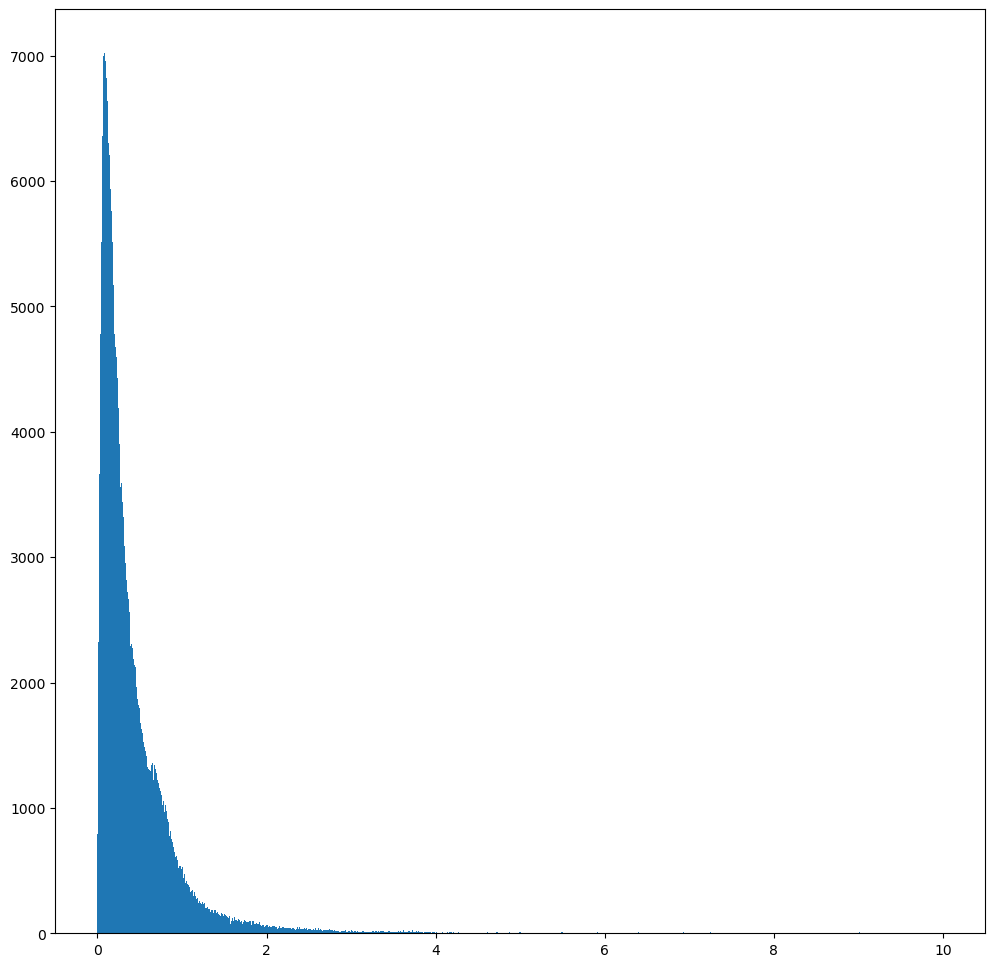

In [7]:
# test some plotting functions

test_obj = stacked_data[2]
sm.plot.plot_hist(test_obj,'Mag_vec', 1000, [0,10])
R_off_compare = getattr(test_obj,'R_off')
A_off_compare = getattr(test_obj,'A_off')
lon_off_compare = getattr(test_obj,'Lon_off')
lat_off_compare = getattr(test_obj,'Lat_off')

In [8]:
plt.close('all')

In [9]:
# %matplotlib inline
# # manually check many different vectors to classify as outlier, inlier and confidence on deformation
# import random
# ## make testing data
# # store R_idx, A_idx, flag
# # flag:
# #   0 : outlier
# #   1 : inlier, no def
# #   2 : inlier, def low conf
# #   3 : inlier, def high conf
# test_data = []
# N_test = 10
# # plt.ion()
# for i in range(N_test):
#     idx = random.randint(0,np.size(test_obj.R_off_vec))
#     sm.plot.plot_rand_vec(test_obj,idx,5,0.002,0.3,2)
#     plt.show(block=False)
#     flag = int(input('what is the flag? 0:outlier, 1:inlier, no def., 2: inlier, def.'))
#     if flag not in [0,1,2,3]:
#         print('ERROR: flag needs to be 0, 1, 2, or 3')
#         break
#     test_data.append([test_obj.R_idx_vec[idx], test_obj.A_idx_vec[idx], flag])
#     plt.close()


In [10]:
# print vector field
%matplotlib osx
# sm.plot.plot_vec_attr(test_obj,'Phase',10,50,[0,360],1,shading,DEM_extent)
sm.plot.plot_vec_attr(test_obj,[],10,50,0.01,[0,360],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])


In [11]:
# test long calculation of local weighted L2
test_obj.calc_local_L2()


0
1000


In [ ]:
# plot local dissimilarity vector
# sm.plot.plot_vec_attr(test_obj,[]   ,10,50,0.01,[0,360],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])

sm.plot.plot_vec_attr(test_obj,'wL2',5 ,50,0.01,[0,5]  ,1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])


In [ ]:
# test HDBSCAN
min_cluster_size = 16 # smallest minimum cluster size
# compute max overlap
overlap = 4*np.ceil((test_obj.R_win/R_STEP) * (test_obj.A_win/A_STEP))
print(overlap)
min_cluster_size = np.max([int(overlap),min_cluster_size])
min_samples = 1

single_cluster = False # setting to true doesn ot break code but makes it run way slower
cluster_selection_epsilon = 0.3 # doesnt do much

80.0


In [ ]:
# run HDBSCAN
test_obj.prep_DBSCAN(1,1,100)
test_obj.run_PCA(4)
test_obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)

In [ ]:
# plot results from HDBSCAN labels and outlier factor
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',3,50,0.01,[-1,0],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_labels',10,50,0.01,[-1,0],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],5,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])


In [ ]:
# remove HDBSCAN outliers
# before
sm.plot.plot_vec_attr(test_obj,'Phase',3,50,0.01,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])

# remove outliers
test_obj.rem_outliers_HDBSCAN()

# after
sm.plot.plot_vec_attr(test_obj,'Phase',3,50,0.01,[0,360],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])
sm.plot.plot_vec_attr(test_obj,'HDBSCAN_outlier_scores',3,50,0.01,[-1,5],1,SHADING,DEM_EXTENT,[-7.546, -7.533],[110.435,110.450])



In [ ]:
# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))
r = 50

indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('R_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

print(stats_list)

coefficients of equation of plane, (a1, a2):  [-0.00091718  0.00021689]
value of intercept, c: 0.013977024562837663
coefficients of equation of plane, (a1, a2):  [0.00211774 0.00061103]
value of intercept, c: -0.031468397089162416
coefficients of equation of plane, (a1, a2):  [-0.00253505 -0.0041242 ]
value of intercept, c: 1.5050519991842213
coefficients of equation of plane, (a1, a2):  [0.00222042 0.00568122]
value of intercept, c: 2.726818511155134
coefficients of equation of plane, (a1, a2):  [-0.00721735  0.00158442]
value of intercept, c: 0.04317531066609137
coefficients of equation of plane, (a1, a2):  [-0.00012442 -0.00061318]
value of intercept, c: 0.2907844527492067
coefficients of equation of plane, (a1, a2):  [ 6.66882883e-05 -4.98906265e-05]
value of intercept, c: 0.0069876926737722014
coefficients of equation of plane, (a1, a2):  [-0.00360678 -0.00157305]
value of intercept, c: -0.009328617489863664
coefficients of equation of plane, (a1, a2):  [-0.00080102 -0.00122539]
v

In [ ]:
def cross_plot(obj,attr1,attr2,mode=0,bins=100,lognorm=0):
        """
            plots cross_plot as scatter (mode=0) or hist2d (mode=1)
            option to plot histogram colours on log scale
        """
        x_data = getattr(obj,attr1).ravel()
        y_data = getattr(obj,attr2).ravel()
        x_data = x_data[~np.isnan(x_data)]
        y_data = y_data[~np.isnan(y_data)]
        if mode == 0:
            fig1, ax0 = plt.subplots(figsize=(12,12))
            ax0.scatter(x_data,y_data,5)
        else:
            fig1, ax0 = plt.subplots(figsize=(12,12))
            if lognorm==0:
                ax0.hist2d(x_data,y_data,bins)
            
            if lognorm==1:
                ax0.hist2d(x_data,y_data,bins,norm=mcolors.LogNorm())

cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',1,300)
# sm.plot.cross_plot(test_obj,'HDBSCAN_outlier_scores','wL2',1,300)

1   HIToolbox                           0x00007ff81ab49726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81ab492b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff81aab8cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff81ab49173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff814616287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff81446b055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   CoreFoundation                      0x00007ff8111803d4 __CFNOTIFICATIONCENTER_IS_CALLING_OUT_TO_AN_OBSERVER__ + 137
8   CoreFoundation                      0x00007ff81121a41a ___CFXRegistrationPost_block_invoke + 88
9   CoreFoundation                      0x00007ff81121a369 _CFXR

In [17]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

In [18]:
# perfrom outlier detection and removal for all windows
import time
start = time.time()
for obj in stacked_data:
    print(f'current window size: {obj.R_win}, {obj.A_win}')
    overlap = 4*np.ceil((obj.R_win/r_step) * (obj.A_win/a_step))
    min_cluster_size = int(overlap)
    min_samples = 1
    # run HDBSCAN
    obj.prep_DBSCAN(1,1,100)
    obj.run_PCA(4)
    obj.run_HDBSCAN(min_cluster_size,min_samples,single_cluster,cluster_selection_epsilon)
    obj.rem_outliers_HDBSCAN()
    print(f'time: {time.time()-start}')


current window size: 42, 20
time: 39.920090198516846
current window size: 74, 36
time: 88.41998529434204
current window size: 108, 52
time: 139.26900625228882
current window size: 140, 68
time: 182.5312361717224
current window size: 174, 84
time: 235.91385221481323
current window size: 206, 100
time: 304.4559631347656
current window size: 240, 116
time: 347.5221211910248
current window size: 272, 132
time: 395.6770660877228
current window size: 306, 148
time: 444.1515781879425
current window size: 340, 164
time: 489.627916097641
current window size: 372, 180
time: 565.0271022319794


In [19]:
# plot range offset for different window sizes to see nan mask
indeces = [0,2,4,6]
r_offset = np.stack([obj.R_off for obj in datastack.Stack])
plot_data = [r_offset[idx] for idx in indeces]
plot_data = plot_data + [np.isnan(r_offset[idx]) for idx in range(4)]
nan_masks = np.stack([np.isnan(r_offset[idx]) for idx in range(4)])
nan_frac = np.sum(nan_masks, axis=0) / 4

fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac)
nan_frac2 = copy.deepcopy(nan_frac)
nan_frac2[nan_frac > 0.5] = np.nan
nan_frac2[nan_frac <= 0.5] = 1
fig=plt.figure(figsize=(7,7))
plt.imshow(nan_frac2)

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys']
min_clim = [-vmax,-vmax,-vmax,-vmax,
            0,0,0,0]

max_clim = [vmax,vmax,vmax,vmax,
            1,1,1,1]


# initiate figure
textsize = 15
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(20,12))
gs=GridSpec(2,4) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(2) for j in range(4)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()

In [20]:
MKA_R_off, MKA_A_off = datastack.Run_MKA([0,2,4,6],comp_lim=0.50)

(3,)
win_i 0


/Users/markbemelmans/Documents/PhD/projects/SPOTSAR/SPOTSAR_main/Post_processing/multikernel.py:276: RuntimeWarning: Mean of empty slice
  Avg_map[win_i + offset, win_j + offset] = np.nanmean(win)
/Applications/anaconda3/envs/PhD/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,


win_i 50
win_i 100
win_i 150
win_i 200
win_i 250
win_i 300
win_i 350
win_i 400
(3,)
win_i 0
win_i 50
win_i 100
win_i 150
win_i 200
win_i 250
win_i 300
win_i 350
win_i 400


In [21]:
from matplotlib.patches import Rectangle
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from cmcrameri import cm

idx_for_plot = [0,2,4,6]
map_extent = [0,446,150,550]
zoom_extent = [140,240,310,390]

substack = [datastack.Stack[i] for i in idx_for_plot]
stack_R = np.stack([obj.R_off for obj in substack],axis=0)
stack_A = np.stack([obj.A_off for obj in substack],axis=0)

plot_data = [stack_R[idx][map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[map_extent[0]:map_extent[1],map_extent[2]:map_extent[3]])
plot_data = plot_data + [stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]] for idx in range(len(idx_for_plot))]
plot_data.append(MKA_R_off[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])
plot_data = plot_data + [np.isnan(stack_R[idx][zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]]) for idx in range(len(idx_for_plot))]
plot_data.append(np.isnan(MKA_R_off)[zoom_extent[0]:zoom_extent[1],zoom_extent[2]:zoom_extent[3]])

cmaps = [cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         cm.vik,cm.vik,cm.vik,cm.vik,cm.vik,
         'Greys','Greys','Greys','Greys','Greys',]
min_clim = [-vmax,-vmax,-vmax,-vmax,-vmax,
            -vmax,-vmax,-vmax,-vmax,-vmax,
            0,0,0,0,0,]

max_clim = [vmax,vmax,vmax,vmax,vmax,
            vmax,vmax,vmax,vmax,vmax,
            1,1,1,1,1,]
all_data_arrays2 = [datastack.Stack[idx] for idx in idx_for_plot]
win_sizes = [str(data.get_window_size()) for data in all_data_arrays2]
win_sizes = win_sizes + ['multi-kernel \naverage']


# initiate figure
textsize = 28
plt.rc('font', size=textsize) 
fig=plt.figure(figsize=(10,10))
gs=GridSpec(3,6) # 3 rows, 5 columns
axes = [fig.add_subplot(gs[i,j]) for i in range(3) for j in range(5)]

for ax,p_data,cmap,clim_min,clim_max in zip(axes,plot_data,cmaps,min_clim,max_clim):
    ax.imshow(p_data,cmap=cmap,vmin=clim_min,vmax=clim_max, interpolation='Nearest')
    ax.set_axis_off()
    
for ax,win_size in zip(axes[0:5],win_sizes):
    ax.add_patch(plt.Rectangle((zoom_extent[2]-map_extent[2], zoom_extent[0]-map_extent[0]), zoom_extent[3]-zoom_extent[2], zoom_extent[1]-zoom_extent[0], ls="-", ec="k", fc="none",
                           ))
    ax.set_title(win_size)

fig.tight_layout()
cbar_pos = axes[4].get_position()
 
cax = plt.axes([cbar_pos.x0+cbar_pos.width + 0.1, cbar_pos.y0-0.08, 0.01, 2 * cbar_pos.height])      
mappable = plt.cm.ScalarMappable(cmap = cm.vik,
                                 norm = plt.Normalize(vmin = -vmax, vmax = vmax))
cbar = fig.colorbar(mappable, cax, orientation = 'vertical')
cbar.set_label('Slant range \noffset [m]', rotation=90, loc= 'center',labelpad=0)

# for ax in axes[0:5]:
#     ax.annotate('slant range',xy=(50,50),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='center',verticalalignment='top',rotation=90)
#     ax.annotate('azimuth',xy=(50,50),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
#                     arrowprops=dict(facecolor='black',arrowstyle='<-'),horizontalalignment='left',verticalalignment='center')
textsize = 24
plt.rc('font', size=textsize) 
for ax in axes[-10:-5]:
    ax.annotate('slant range',xy=(5,5),xytext=(0,-50),textcoords='offset pixels', xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='center',verticalalignment='top',rotation=90)
    ax.annotate('azimuth',xy=(5,5),xytext=(50,0),textcoords='offset pixels' ,xycoords='data',
                    arrowprops=dict(facecolor='black',arrowstyle='<-',lw=3),horizontalalignment='left',verticalalignment='center')

# fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


In [23]:
plt.close('all')

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import rasterio as rio
import fiona
import geopandas as gpd

import json
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


# get NDVI data
file_name = '../Merapi2021/sentinel2/S2A_MSIL2A_20200821T023551_N0214_R089_T49MDM_20200821T064209.SAFE/GRANULE/L2A_T49MDM_A026970_20200821T025827/IMG_DATA/R10m/T49MDM_20200821T023551_NDVI_10m_WGS84.tif'
# with rio.open(file_name) as src:
#     band1 = src.read(1)
#     print('Band1 has shape', band1.shape)
#     height = band1.shape[0]
#     width = band1.shape[1]
#     cols, rows = np.meshgrid(np.arange(width), np.arange(height))
#     xs, ys = rio.transform.xy(src.transform, rows, cols)
#     ndvi_lons = np.array(xs)
#     ndvi_lats = np.array(ys)
#     ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


# define map region of interest
lon_lims = [np.nanmin(lon_off_compare), np.nanmax(lon_off_compare)]
lat_lims = [np.nanmin(lat_off_compare), np.nanmax(lat_off_compare)]
crop_flag=1

# create cropping polygon from ROI
if crop_flag:
    coords = ((lon_lims[0], lat_lims[0]), (lon_lims[0], lat_lims[1]), (lon_lims[1], lat_lims[1]), (lon_lims[1], lat_lims[0]), (lon_lims[0], lat_lims[0]))
    crop_poly = Polygon(coords)
    crop_poly_geojson = gpd.GeoSeries([crop_poly])
    crop_poly_geojson.to_file('./test_data/test_variability_roi.shp',crs="EPSG:4326")

with fiona.open('./test_data/test_variability_roi.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

# get data and read coords from first file
with rio.open(file_name) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})
with rasterio.open("./test_Data/ndvi_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)



with rio.open("./test_Data/ndvi_cropped.tif") as src:
    ndvi_map = src.read(1)
    print('Band1 has shape', ndvi_map.shape)
    height = ndvi_map.shape[0]
    width = ndvi_map.shape[1]
    cols, rows = np.meshgrid(np.arange(width), np.arange(height))
    xs, ys = rio.transform.xy(src.transform, rows, cols)
    ndvi_lons = np.array(xs)
    ndvi_lats = np.array(ys)
    ndvi_extent = [src.bounds.left,src.bounds.right,src.bounds.bottom,src.bounds.top]


x= cm.get_cmap('Blues_r', 135)
y= cm.get_cmap('YlGn', 135)
z = np.vstack((x(range(135)),
                       y(range(135))))
ndvi_cmap = ListedColormap(z, name='BlYlGn')

Band1 has shape (749, 731)


/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_52179/411787338.py:69: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  x= cm.get_cmap('Blues_r', 135)
/var/folders/m9/32v45xkn4zx6js6htb1prb2r0000gn/T/ipykernel_52179/411787338.py:70: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  y= cm.get_cmap('YlGn', 135)


In [54]:
# %matplotlib osx

# fig, ax = plt.subplots(1,1,figsize=(10,10))
# ax.imshow(ndvi_map,cmap=ndvi_cmap,extent=ndvi_extent,vmin=-1,vmax=1)

In [24]:
# test query point

# query points
q1 = [110.446216,-7.536389] # stable no veg north
q2 = [110.42647,-7.53297] # stable veg north west
q3 = [110.4421429,-7.5377992] # L1888
q4 = [110.44214,-7.54237] # L1998 large disp
q5 = [110.44013,-7.54678] # stable no veg south
q6 = [110.44200,-7.53604] # L1956 offset gradient
query_points = np.stack((q1,q2,q3,q4,q5,q6))

r = 50 # radius of 5 meters around point


# original window size 108-52
orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               R_off_compare.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Range mean for A, B, C: {orig_q_mean}')
print(f'Range median for A, B, C: {orig_q_median}')
print(f'Range standard deviation for A, B, C: {orig_q_std}')
print(f'Range 95\% confidence interval fro A, B, C: {orig_q_95}')

# MKA reuslt
MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               MKA_R_off.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Range mean for A, B, C: {MKA_q_mean}')
print(f'Range median for A, B, C: {MKA_q_median}')
print(f'Range standard deviation for A, B, C: {MKA_q_std}')
print(f'Range 95\% confidence interval fro A, B, C: {MKA_q_95}')

# original window size 108-52 azimuth
orig_q_mean, orig_q_median, orig_q_std, orig_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               A_off_compare.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Azimuth mean for A, B, C: {orig_q_mean}')
print(f'Azimuth median for A, B, C: {orig_q_median}')
print(f'Azimuth standard deviation for A, B, C: {orig_q_std}')
print(f'Azimuth 95\% confidence interval fro A, B, C: {orig_q_95}')

# MKA reuslt
MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95, coordinate_circles = sm.Post_processing.query_point(lat_off_compare.flatten(),
                                                               lon_off_compare.flatten(),
                                                               MKA_A_off.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'Azimuth mean for A, B, C: {MKA_q_mean}')
print(f'Azimuth median for A, B, C: {MKA_q_median}')
print(f'Azimuth standard deviation for A, B, C: {MKA_q_std}')
print(f'Azimuth 95\% confidence interval fro A, B, C: {MKA_q_95}')


# NDVI reuslt
ndvi_q_mean, ndvi_q_median, ndvi_q_std, ndvi_q_95, coordinate_circles = sm.Post_processing.query_point(ndvi_lats.flatten(),
                                                               ndvi_lons.flatten(),
                                                               ndvi_map.flatten(),
                                                               query_points[:,1],
                                                               query_points[:,0],
                                                               r)
print('\n')
print(f'mean for A, B, C: {ndvi_q_mean}')
print(f'median for A, B, C: {ndvi_q_median}')
print(f'standard deviation for A, B, C: {ndvi_q_std}')
print(f'95\% confidence interval fro A, B, C: {ndvi_q_95}')

coefficients of equation of plane, (a1, a2):  [ 6.66882883e-05 -4.98906265e-05]
value of intercept, c: 0.0069876926737722014
coefficients of equation of plane, (a1, a2):  [-0.00360678 -0.00157305]
value of intercept, c: -0.009328617489863664
coefficients of equation of plane, (a1, a2):  [-0.00080102 -0.00122539]
value of intercept, c: 1.5846041311627426
coefficients of equation of plane, (a1, a2):  [-0.00512863  0.00539831]
value of intercept, c: 3.387684773160212
coefficients of equation of plane, (a1, a2):  [ 0.00016792 -0.00023534]
value of intercept, c: 0.02570186448762592
coefficients of equation of plane, (a1, a2):  [ 0.00128515 -0.0015199 ]
value of intercept, c: 0.25155241087550984


Range mean for A, B, C: [ 0.00698769 -0.00932862  1.58460413  3.38768477  0.02570186  0.25155241]
Range median for A, B, C: [ 0.01252847 -0.05552147  1.58209528  3.38671313  0.02715618  0.25089094]
Range standard deviation for A, B, C: [0.04678563 0.38823887 0.07024511 0.70172086 0.02363273 0.02838

In [28]:
indeces = [0,2,4,6]
stats_list, coordinate_circles = datastack.query_point_stack('A_off_vec',
                                                             query_points[:,1],
                                                             query_points[:,0],
                                                             r,
                                                             indeces)

[q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA], coordinate_circles = datastack.query_point_MKA('MKA_A_off',
                                                                                                 query_points[:,1],
                                                                                                 query_points[:,0],
                                                                                                 r)                                                        

coefficients of equation of plane, (a1, a2):  [-0.00451784  0.00209096]
value of intercept, c: -0.3100504885023444
coefficients of equation of plane, (a1, a2):  [-0.00432668  0.00090122]
value of intercept, c: 0.011557031794686623
coefficients of equation of plane, (a1, a2):  [-0.00147404  0.00956614]
value of intercept, c: -1.270581278993684
coefficients of equation of plane, (a1, a2):  [-0.00472849 -0.00113842]
value of intercept, c: -0.02638989691779352
coefficients of equation of plane, (a1, a2):  [-0.00855154  0.00153969]
value of intercept, c: -0.025456067097120488
coefficients of equation of plane, (a1, a2):  [-0.00459464  0.00115914]
value of intercept, c: -0.3176953460874315
coefficients of equation of plane, (a1, a2):  [ 0.00106583 -0.00079658]
value of intercept, c: -0.1472000814514849
coefficients of equation of plane, (a1, a2):  [-0.000511   -0.00393086]
value of intercept, c: 0.05982668623587263
coefficients of equation of plane, (a1, a2):  [-0.00277989  0.00310346]
value

CRSError: Invalid projection: +proj=aeqd +R=6371000 +units=m +lat_0=110.446216 +lon_0=-7.536389 +type=crs: (Internal Proj Error: proj_create: Error -22: lat_0, lat_1 or lat_2 >= 90)

In [29]:
print(stats_list)
# print(q_mean_MKA, q_median_MKA, q_std_MKA, q_95_MKA)
print(MKA_q_mean, MKA_q_median, MKA_q_std, MKA_q_95)

[[42, 20, array([-0.31005049,  0.01155703, -1.27058128, -0.0263899 , -0.02545607,
       -0.31769535]), array([-0.20637143,  0.05049244, -1.30401724,  0.21463332, -0.02804826,
       -0.36407359]), array([0.66187568, 0.69109352, 0.80172105, 1.00181359, 0.73432163,
       0.29945002]), array([[-1.96172359,  0.50637838],
       [-1.60242468,  1.63322298],
       [-2.86456945,  1.09648479],
       [-2.30744345,  1.37022873],
       [-1.73780216,  1.48305093],
       [-0.64862894,  0.14176819]])], [108, 52, array([-0.14720008,  0.05982669, -1.474513  ,  0.09731945, -0.06670085,
       -0.33513416]), array([-0.13940524, -0.03413634, -1.47559132,  0.23834724, -0.06474557,
       -0.34944578]), array([0.1080932 , 0.36596801, 0.19619553, 0.90230471, 0.07069637,
       0.07656541]), array([[-0.46852124,  0.04200563],
       [-0.33213582,  0.64725801],
       [-1.88930608, -1.14355556],
       [-0.91372464,  0.90598653],
       [-0.19601848,  0.08523041],
       [-0.45365842, -0.19591733]])], [1

In [ ]:
# make plot for comparison
# 1 original input mid window size
# 2 outlier removed-mka result
# 3 ndvi
from cmcrameri import cm
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

data2plot = [R_off_compare,MKA_R_off,ndvi_map]
lon2plot = [lon_off_compare,lon_off_compare,ndvi_lons]
lat2plot = [lat_off_compare,lat_off_compare,ndvi_lats]
cmaps = [cm.vik,cm.vik,ndvi_cmap]
vmins = [-3,-3,-1]
vmaxs = [3,3,1]
cbar_labels = ['Slant range\noffset [m]', 'Slant range\noffset [m]', 'NDVI [-]']
lon_lims = [110.42, 110.45]
lat_lims = [-7.55, -7.53]
# q1 = [110.446216,-7.536389]
# q2 = [110.427882,-7.530558]
# q3 = [110.4421429,-7.5377992]

distance_meters = sm.plot.get_1deg_dist()


fig, ax = plt.subplots(3,1,figsize=(4,12))
for i,(data,lon_p,lat_p,cmap,vmin,vmax,cbar_label) in enumerate(zip(data2plot,lon2plot,lat2plot,cmaps,vmins,vmaxs,cbar_labels)):
    plot_extent = [np.nanmin(lon_p),np.nanmax(lon_p),np.nanmin(lat_p),np.nanmax(lat_p)]
    plot_data = ax[i].hexbin(lon_p.flatten(),lat_p.flatten(),C=data.flatten(),gridsize=500,cmap=cmap,vmin=vmin,vmax=vmax)
    ax[i].plot(coordinate_circles[0][:,0],coordinate_circles[0][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[1][:,0],coordinate_circles[1][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[2][:,0],coordinate_circles[2][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[3][:,0],coordinate_circles[3][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[4][:,0],coordinate_circles[4][:,1],color='Black',linewidth=3)
    ax[i].plot(coordinate_circles[5][:,0],coordinate_circles[5][:,1],color='Black',linewidth=3)
    ax[i].set_xlim(lon_lims)
    ax[i].set_ylim(lat_lims)
    ax[i].set_aspect('equal', 'box')
    ax[i].add_artist(ScaleBar(distance_meters,location='lower left'))
    ax[i].set_axis_off()
    cbar = plt.colorbar(plot_data,ax=ax[i])
    cbar.set_label(cbar_label)

1   HIToolbox                           0x00007ff81ad2d726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81ad2d2b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff81ac9ccd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff81ad2d173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff8147fa287 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff81464f055 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff81509d7f0 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff814ef05d8 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


In [ ]:
# plt.close('all')